In [3]:
import numpy as np
import random
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

%run functions.py

In [2]:
class GenAlg:

    def __init__(self, population_size, k_crossover, mutation_prob, rates, sigma):
        self.population_size = population_size
        self.k = k_crossover
        self.mutation_prob = mutation_prob
        self.number_of_stocks = len(rates)

        self.rates = rates.copy()
        self.sigma = sigma.copy()

        self.random_pop()
    


    def random_pop(self):
        self.population = np.random.rand(self.population_size,self.number_of_stocks)
        for  i in range(self.population.shape[0]):
            self.population[i,] = self.normalize(self.population[i,])
    
    def normalize(self,vector):
        sum_of_vector = sum(vector)
        for i in range(len(vector)):
            vector[i] =  vector[i]/sum_of_vector
        return vector
    
    def evaluate(self):
        best_fitness = None
        best = None
        for vector in self.population:
            f = self.fitness(vector)
            if best is None or f > best_fitness:
                best = vector
                best_fitness = f
        return best_fitness,best

    def fitness(self,vector):
        rate = np.sum(vector * self.rates)
        volatility = np.sqrt(np.dot(vector.T,np.dot(self.sigma,vector)))

        return rate/volatility

    def get_lucky_one(self):
        random_num = random.randrange(len(self.population))
        return self.population[random_num,:]
    
    def select_parents(self,lucky_one):
        # if lucky_one exists then remove him
        if lucky_one is not None:
            pop = np.ones(shape=(self.population_size-1,self.number_of_stocks))
            i = 0
            for vec in self.population:
                if not (vec == lucky_one).all():
                    pop[i,:] = vec
                    i+=1
        else:
            pop = self.population.copy()
        
        new_pop = np.array(sorted(pop,key=self.fitness,reverse=True))

        return new_pop[:len(new_pop)//2,:]

    def create_children(self,parents):
        
        children = np.zeros(shape=(self.population_size//2,self.number_of_stocks))
        np.random.shuffle(parents)
        first_p, second_p = map(list,np.split(parents,2))
        for i in range(len(parents)//2):
            parent1 = first_p.pop(0)
            parent2 = second_p.pop(0)

            child1, child2 = self.k_crossover(parent1,parent2)

            child1 = self.mutation(child1)
            child2 = self.mutation(child2)

            child1 = self.normalize(child1)
            child2 = self.normalize(child2)

            children[i,:] = child1
            children[i+len(parents)//2,:] = child2

        return children 
    
    def k_crossover(self,x,y):

        slices = set()
        while len(slices) < self.k-1:
            slice_index = random.choice([i for i in range(1,len(x)) if i not in slices])
            if slice_index not in slices:
                slices.add(slice_index)

        slices = sorted(list(slices))
        slices.append(self.number_of_stocks)

        new_x = np.zeros(self.number_of_stocks)
        new_y = np.zeros(self.number_of_stocks)

        first = 0
        switch = True
        for second in slices:
            if switch:
                new_x[first:second] = x[first:second]
                new_y[first:second] = y[first:second]
            else:
                new_x[first:second] = y[first:second]
                new_y[first:second] = x[first:second]
            first = second
            switch = not switch

        return new_x,new_y

    def mutation(self,child):
        for i in range(len(child)):
            if random.random() < self.mutation_prob:
                child[i] += random.gauss(0.1,0.05)
        return child

    def solve(self,max_generations, goal):
        
        best_fit, best = self.evaluate()
        
        for iteration in range(max_generations):
            #print(iteration,'iteration',end=' ')
            if best_fit > goal:
                break

            lucky_one = None
            if len(self.population)%2 == 1:
                lucky_one = self.get_lucky_one()

            parents = self.select_parents(lucky_one)

            children = self.create_children(parents)

            if lucky_one is not None:
                lucky_one = lucky_one.reshape((1,len(lucky_one)))
                self.population = np.concatenate((lucky_one,parents,children),axis=0)
            else:
                self.population = np.concatenate((parents,children),axis=0)

            best_fit, best = self.evaluate()
            #print('best ratio:',best_fit)
        #print('finnished')
        return best,best_fit

# Nastavovanie parametrov

In [5]:
wanted_stocks = ['GOOG', 'SPG', 'GOOGL', 'MSFT', 'GD', 'ACN', 'COP', 'F', 'BAC', 'GS',
                'NVDA', 'AIG', 'MS', 'WFC', 'ORCL', 'XOM', 'TGT', 'LOW', 'EXC', 'COST',
                'AXP', 'BK', 'JPM', 'COF', 'CSCO', 'DHR', 'UNH', 'CVS', 'LLY', 'CVX',
                'MET', 'AMT', 'CRM', 'BLK', 'RTX', 'MCD', 'TMO', 'LIN', 'ADBE', 'EMR',
                'USB', 'UPS', 'TSLA', 'PFE', 'PM']
stocks = pd.read_csv('data/sap100_data_08112021.csv',index_col=0).loc[:,wanted_stocks]
returns = stocks/stocks.shift(1)-1
rates = returns.mean() * 252
sigma = returns.cov() * 252

## k in k-crossover

In [67]:
k_data_dict = {'k':[],'ratio':[],'stocks >= 1%':[]}

for k in range(2,40):
    ratios = np.zeros(50)
    stocks = np.zeros(50)
    for i in range(50):
        solver = GenAlg(population_size=100,k_crossover=k,mutation_prob=0.01,rates=rates,sigma=sigma)
        best,best_fit = solver.solve(10,10)
        ratios[i] = best_fit

        for weight in best:
            if weight >= 0.01:
                stocks[i]+=1
    k_data_dict['k'].append(k)
    k_data_dict['ratio'].append(np.mean(ratios))
    k_data_dict['stocks >= 1%'].append(np.mean(stocks))
k_data = pd.DataFrame(k_data_dict)
k_data.head()

,k,ratio,stocks >= 1%
0,2,4.231948,30.42
1,3,4.250182,30.28
2,4,4.264817,30.44
3,5,4.275932,30.06
4,6,4.281919,29.22


In [68]:
custom_plot(k_data['k'],k_data['ratio'],k_data['stocks >= 1%'],'k','ratio','stocks >= 1%')

## mutation propability

In [69]:
np.logspace(-3,-0.3,40)

array([0.001     , 0.00117282, 0.0013755 , 0.00161322, 0.00189201,
       0.00221898, 0.00260246, 0.00305222, 0.0035797 , 0.00419833,
       0.00492388, 0.00577482, 0.00677282, 0.00794328, 0.00931603,
       0.01092601, 0.01281422, 0.01502876, 0.017626  , 0.0206721 ,
       0.02424462, 0.02843454, 0.03334855, 0.03911179, 0.04587103,
       0.05379838, 0.06309573, 0.07399984, 0.08678837, 0.101787  ,
       0.11937766, 0.14000832, 0.16420433, 0.19258186, 0.22586355,
       0.26489693, 0.31067599, 0.36436652, 0.42733575, 0.50118723])

In [70]:
mutation_data_dict = {'mutation prob':[],'ratio':[],'stocks >= 1%':[]}

for p in np.logspace(-3,-0.3,40):
    ratios = np.zeros(50)
    stocks = np.zeros(50)
    for i in range(50):
        solver = GenAlg(population_size=100,k_crossover=28,mutation_prob=p,rates=rates,sigma=sigma)
        best,best_fit = solver.solve(10,10)
        ratios[i] = best_fit

        for weight in best:
            if weight >= 0.01:
                stocks[i]+=1
    mutation_data_dict['mutation prob'].append(p)
    mutation_data_dict['ratio'].append(np.mean(ratios))
    mutation_data_dict['stocks >= 1%'].append(np.mean(stocks))
mutation_data = pd.DataFrame(mutation_data_dict)
mutation_data.head()

,mutation prob,ratio,stocks >= 1%
0,0.001000,4.263722,30.30
1,0.001173,4.270889,30.46
2,0.001376,4.269530,30.54
3,0.001613,4.265949,31.30
4,0.001892,4.273394,30.80


In [71]:
custom_plot(mutation_data['mutation prob'],mutation_data['ratio'],mutation_data['stocks >= 1%'],'mutation prob','ratio','stocks >= 1%')

# vhodné parametre?
## k = 10
## p = 0.01

In [12]:
g = GenAlg(population_size=100, k_crossover=10, mutation_prob=0.01, rates=rates,sigma=sigma)

best,best_fit = g.solve(10,8)
print(best,best_fit)
menej_ako_jedno_percenta = [i for i in best if i < 0.01]
print('pocet akcii v portfoliu:', 45-len(menej_ako_jedno_percenta))

[0.03974211 0.03826552 0.01608535 0.0359793  0.03662565 0.01598428
 0.02465983 0.03447866 0.02956832 0.00044483 0.0372205  0.00410072
 0.01263438 0.00455718 0.02953853 0.02475763 0.01477765 0.03298475
 0.03250323 0.0177319  0.00890489 0.02923145 0.0049246  0.00542014
 0.00120123 0.03804    0.03473402 0.02834765 0.10019161 0.0047493
 0.00153882 0.04070861 0.01488756 0.01127172 0.00073952 0.04121845
 0.01883959 0.00047114 0.00839191 0.01284843 0.00878469 0.00917173
 0.02722302 0.04010156 0.02541803] 4.292069423269097
pocet akcii v portfoliu: 31


4.288565185575762

In [14]:
df_vysledok = pd.DataFrame({"w":[0.01645208, 0.0322002,  0.01365159,0.08322032, 0.03114179, 0.02503631,
 0.02852424, 0.03133215, 0.00896659, 0.02004556, 0.01606103, 0.01750719,
 0.00217907, 0.01416346, 0.12899603, 0.01344529, 0.00154887, 0.02063509,
 0.01917004, 0.0287973,  0.01228395, 0.00902642, 0.01862372, 0.00800605,
 0.01203194, 0.03146646, 0.02361481, 0.00148632, 0.10470478, 0.01947316,
 0.00611707, 0.0183105,  0.02571685, 0.00999524, 0.00030258, 0.00796955,
 0.02272337, 0.00152548, 0.01253436, 0.00851215, 0.00813952, 0.00551268,
 0.02363687, 0.03742157, 0.01779043], "stocks" : ['GOOG', 'SPG', 'GOOGL', 'MSFT', 'GD', 'ACN', 'COP', 'F', 'BAC', 'GS',
                'NVDA', 'AIG', 'MS', 'WFC', 'ORCL', 'XOM', 'TGT', 'LOW', 'EXC', 'COST',
                'AXP', 'BK', 'JPM', 'COF', 'CSCO', 'DHR', 'UNH', 'CVS', 'LLY', 'CVX',
                'MET', 'AMT', 'CRM', 'BLK', 'RTX', 'MCD', 'TMO', 'LIN', 'ADBE', 'EMR',
                'USB', 'UPS', 'TSLA', 'PFE', 'PM']})
df_vysledok.sort_values('w', ascending=False).head()

,w,stocks
14,0.128996,ORCL
28,0.104705,LLY
3,0.083220,MSFT
43,0.037422,PFE
1,0.032200,SPG


In [16]:
plot_sectors(df_vysledok['w'].to_numpy())

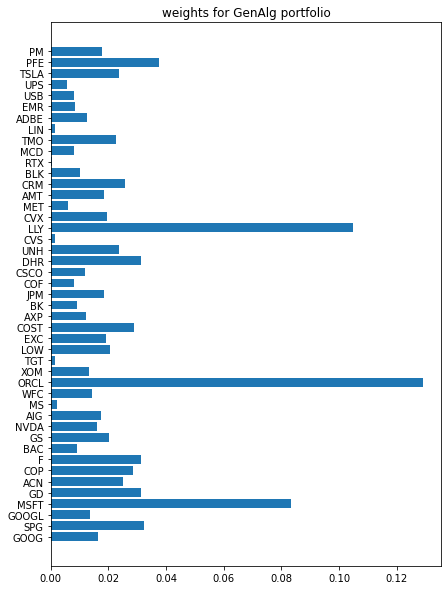

In [18]:
plt.figure(figsize=(7,10))
plt.barh(df_vysledok['stocks'],df_vysledok['w'])
plt.title('weights for GenAlg portfolio')
plt.show()